# Deep Kernel flow

In [1]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", True)
config.update("jax_disable_jit", False)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
import json_tricks as json
import copy
from functools import partial
import warnings

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import models
import flows

from jax.experimental import optimizers

key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


### Main

In [2]:
d = 20
target = distributions.Gaussian(np.zeros(d), np.ones(d)*25)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
setup = distributions.Setup(target, proposal)

In [3]:
# %matplotlib inline
# # setup = distributions.banana_target
# # target, proposal = setup.get()
# target = distributions.Gaussian([0, 0], [1e-2, 1])
# proposal = distributions.Gaussian([0,0], 1)
# setup = distributions.Setup(target, proposal)
# # target = distributions.Banana([0, 0], [4, 1])
# # proposal = distributions.Gaussian([-5, -5], 1)
# # setup = distributions.Setup(target, proposal)
# setup.plot(lims=(-15, 15))

In [4]:
%autoreload

In [30]:
key, subkey = random.split(key)

In [31]:
n_steps = 100
noise = 0.
n_particles = 50
sizes = [16, 16, 2]
# key, subkey = random.split(key)
particle_lr = 7e-2

learner, neural_particles, err1         = flows.deep_kernel_flow(subkey, setup, n_steps=n_steps, particle_lr=particle_lr, noise_level=noise, sizes=sizes, learner_lr=1e-1)
kernel_gradient, kernel_particles, err2 = flows.svgd_flow(subkey, setup, n_steps=n_steps, particle_lr=particle_lr, noise_level=0, scaled=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Traced<ShapedArray(float32[]):JaxprTrace(level=-1/1)>


100%|██████████| 100/100 [00:07<00:00, 13.60it/s]


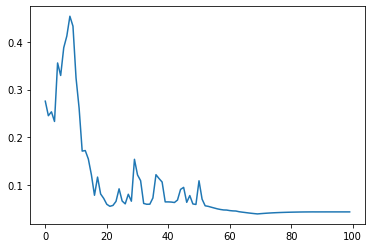

In [32]:
plt.plot(learner.rundata["mean_k"])

## what does the learned kernel do?

In [8]:
train_x, *_ = neural_particles.get_params(split_by_group=True)
kernel = learner.get_kernel_fn(train_x)
kvalues = vmap(kernel, (None, 0))(train_x[0], train_x[1:])
kvalues

DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0.], dtype=float32)

(array([ 0.,  0.,  0.,  0.,  0., 49.,  0.,  0.,  0.,  0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5],
       dtype=float32),
 <BarContainer object of 10 artists>)

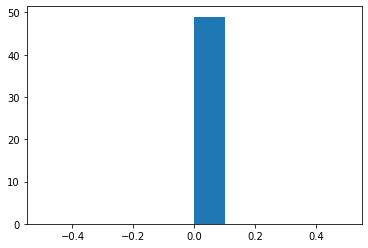

In [9]:
plt.hist(kvalues)

In [10]:
np.count_nonzero(kvalues > 1e-1)

DeviceArray(0, dtype=int32)

In [24]:
# learner.get_params()

## Plot

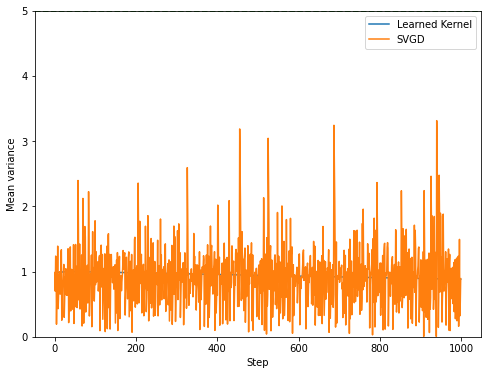

In [25]:
%matplotlib inline
plt.subplots(figsize=[8, 6])
plt.ylim((0, 5))
stdneur = np.array(neural_particles.rundata["training_std"])
stdsvgd = kernel_particles.rundata["training_std"]
plt.plot(np.mean(stdneur, axis=1), color="tab:blue", label="Learned Kernel")
plt.plot(onp.mean(stdsvgd, axis=1), color="tab:orange", label="SVGD")
_ = plt.axhline(y=5, color="green", linestyle="--")
plt.ylabel("Mean variance")
plt.xlabel("Step")
plt.legend()

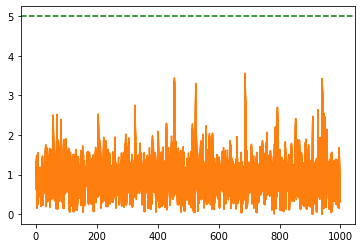

In [13]:
%matplotlib inline
stdneur = neural_particles.rundata["validation_std"]
stdsvgd = kernel_particles.rundata["validation_std"]
plt.plot(stdneur, color="tab:blue", label="neur")
_ = plt.plot(stdsvgd, color="tab:orange")
_ = plt.axhline(y=5, color="green", linestyle="--")
# plt.legend()

In [14]:
# paramtree = utils.dict_concatenate(learner.rundata["model_params"])

# leaves, structure = jax.tree_flatten(paramtree)

# h = np.array(leaves[0])
# bw = np.exp(h)
# s = np.array(leaves[1])

# %matplotlib inline
# plt.plot(h, "--", label="bandwidth", color="tab:blue")
# plt.plot(s, "--", label="scale", color="tab:orange")
# plt.ylim((None, None))
# # plt.legend()

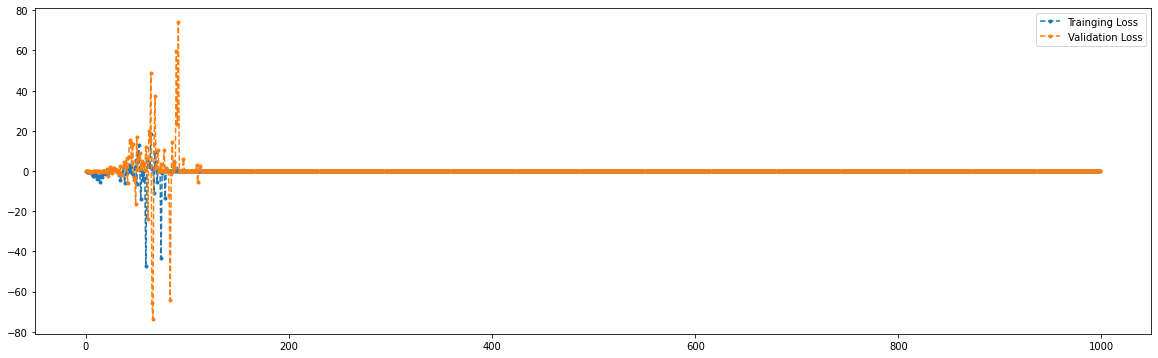

In [26]:
%matplotlib inline
plt.subplots(figsize=[20, 6])
plt.plot(learner.rundata["training_loss"], "--.", label="Trainging Loss")
plt.plot(learner.rundata["validation_loss"], "--.", label="Validation Loss")
plt.legend()
# plt.ylim((-.2, 0))

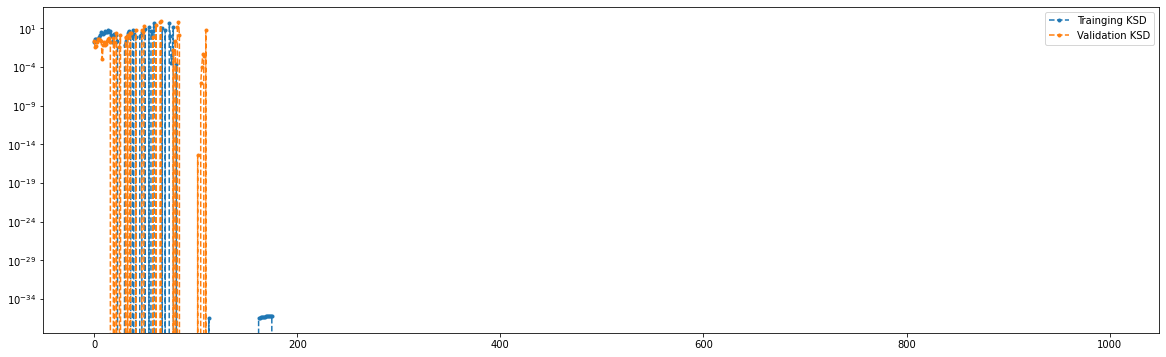

In [27]:
%matplotlib inline
plt.subplots(figsize=[20, 6])
plt.plot(learner.rundata["training_ksd"], "--.", label="Trainging KSD")
plt.plot(learner.rundata["validation_ksd"], "--.", label="Validation KSD")
plt.legend()
plt.yscale("log")

## plot plojection of kernel

In [18]:
x = np.array([0, 0])
x50d = np.append(x, train_x[0, 2:])

In [19]:
x50d.shape

(20,)

In [20]:
kernel = learner.get_kernel_fn(train_x)
def kfn(x):
    return kernel(train_x[0], x)
slice_dims=[0, 1]

def kfn_sliced(x):
    """2d slice of kfn"""
    x50d = np.append(x, train_x[0, 2:])
    return kfn(x50d)

In [21]:
kernel(train_x[0], train_x[0])

DeviceArray(4.7256193, dtype=float32)

In [22]:
kfn_sliced(train_x[0, :2]-.3)

DeviceArray(0.18939534, dtype=float32)

In [23]:
plot.plot_fun_2d(kfn_sliced, lims=lim)

NameError: name 'lim' is not defined

## plot projection of particles

In [ ]:
%matplotlib inline
train_x, val_x = neural_particles.get_params(split_by_group=True)

fig, axs = plt.subplots(1, 3, figsize=[25, 8])
axs = axs.flatten()
lim=(-10, 10)
for ax in axs:
    ax.set(xlim=lim, ylim=lim)

plot.plot_fun_2d(distributions.Gaussian([0,0], [1,1]).pdf, ax=axs[0], lims=lim)
for particles in (train_x, val_x):
    axs[0].scatter(particles[:, 0], particles[:, 1])
axs[0].set_title("Neural SVGD") 

ax=axs[1]
strain_x, sval_x = kernel_particles.get_params(split_by_group=True)
plot.plot_fun_2d(distributions.Gaussian([0,0], [1,1]).pdf, ax=ax, lims=lim)
for particles in (strain_x, sval_x):
    ax.scatter(particles[:, 0], particles[:, 1])
ax.set_title("SVGD") 

In [ ]:
trajectory.shape

In [ ]:
trajectory = np.array(neural_particles.rundata["particles"])
trajectory_projected = trajectory[:, :, [0, 1]]
t_train, t_val = [trajectory_projected[:, idx, :] for idx in neural_particles.group_idx]

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(figsize=[8, 8])
lim=(-5, 5)
ax.set(xlim=lim, ylim=lim)
interval=100
anim=[]
for t in [t_train, t_val]:
    anim.append(plot.animate_array(t, fig=fig, ax=ax, interval=interval))

# regular 2d plots

In [ ]:
## %matplotlib inline
fig, axs = plt.subplots(1, 3, figsize=[25, 8])
axs = axs.flatten()
lim=(-10, 10)
for ax in axs:
    ax.set(xlim=lim, ylim=lim)
ax1 = neural_particles.plot_final(ax=axs[0], target=target, cmap="Greens")
ax1.set_title("Neural SVGD")

ax2 = kernel_particles.plot_final(ax=axs[1], target=target, cmap="Greens")
ax2.set_title("SVGD")

ax = axs[2]
plot.plot_fun_2d(target.pdf, lims=lim, ax=ax, cmap="Greens")
plot.scatter(target.sample(50), ax=ax, color="tab:orange")
ax.set_title("True Samples")

In [ ]:
neural_trajectories = np.asarray(neural_particles.rundata["particles"])
kernel_trajectories = np.asarray(kernel_particles.rundata["particles"])

In [ ]:
np.var(neural_trajectories[-1], axis=0)

In [ ]:
np.var(kernel_trajectories[-1], axis=0)

In [ ]:
%matplotlib widget
fig, axs = plt.subplots(1, 2, figsize=[14, 6])
axs=axs.flatten()
lim=(-10, 10)
for ax in axs:
    ax.set(xlim=lim, ylim=lim)

animations = []
for ax, trajectories, title in zip(axs, [neural_trajectories, kernel_trajectories], ["Neural", "Kernel"]):
    ax.set_title(title)
    plot.plot_fun_2d(target.pdf, lims=lim, ax=ax)
    animations.append(plot.animate_array(trajectories, fig, ax))